# Nokia Project
### A Methodology for the Automated Classification and Identification of Solvable Networking Performance Problems
### HTTP LIVE PAGE DL with Avg. Session Time 500kB DL

In [4]:
# Generic libraries
import pandas as pd
import numpy  as np
from sklearn import metrics 
import os
import random
# Plotting
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn import tree
import graphviz
import matplotlib.font_manager
from matplotlib.pylab import rcParams
import seaborn as sns

# Pre-processing
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler
from fastautoml.fastautoml import Miscoding, AutoClassifier

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from Nescience_paper import NescienceDecisionTreeClassifier
# Clustering
from sklearn.cluster import KMeans
import pydotplus
import random
# Scoring
from sklearn.model_selection import cross_val_score

### Prepare dataset

Load Data

In [6]:
data = pd.read_csv("X_y_full_LTE.csv")
data.shape

(6690, 451)

Select data from relavant attributes

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6690 entries, 0 to 6689
Columns: 451 entries, Test.Throughput.kbit.s to Abs_PacketLost_Acc_TimeStep_20480ms
dtypes: float64(402), int64(49)
memory usage: 23.0 MB


Only numeric data types

In [8]:
data = data.select_dtypes(['number'])

In [9]:
data.shape

(6690, 451)

In [10]:
data = data.replace([np.inf, -np.inf], np.nan)

Drop NA

In [11]:
data = data.dropna(axis=1)
data.shape

(6690, 228)

In [12]:
X_r = data.copy()
y_r = X_r["Test.Throughput.kbit.s"]
X_r = X_r.drop(["Test.Throughput.kbit.s"], axis=1)
column_names = np.array(X_r.columns)

In [13]:
X = X_r.values
y = y_r.values

# Optimal bins for target variable

In [14]:
Target_r = data["Test.Throughput.kbit.s"].values

Compute the optimal number of bins

In [15]:
# Based on the size of the dataset and the number of leafs
n_bins = int(np.log2(len(Target_r))/2)
n_bins

6

In [16]:
dTarget_r = Target_r.copy()
dTarget_r = dTarget_r.reshape(-1, 1)

# We use "kmeans" instead of "uniform" because the target could have outliers
est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='kmeans')
est.fit(dTarget_r)
dTarget_r = est.transform(dTarget_r)
dTarget_r = dTarget_r[:,0]

In [17]:
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

In [18]:
def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
#         print(height)
#         print(bar_label[idx])
        ax.text(rect.get_x()+rect.get_width()/1.78, 1.02*height, '%s'% (bar_label[idx]),
                ha='center', va='bottom')

<Figure size 1440x720 with 0 Axes>

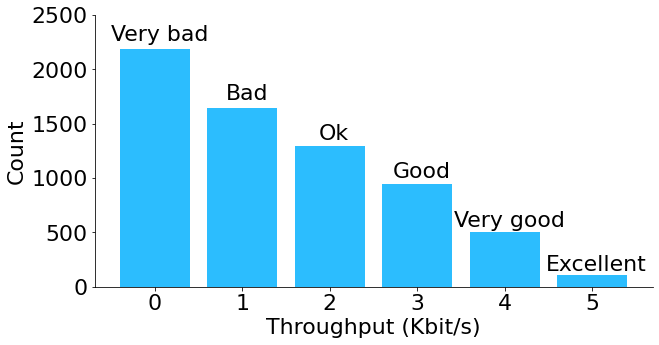

In [21]:
plt.figure(figsize=(20,10))

matplotlib.rcParams.update({'font.size': 22})
plt.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
val, count = np.unique(dTarget_r, return_counts=True)
bar_label = ["Very bad", "Bad", "Ok", "Good", "Very good", "Excellent"]


fig, ax = plt.subplots(figsize=(10,5))
bar_plot = plt.bar(val, count, color = "#2CBDFE")
plt.xlabel("Throughput (Kbit/s)")
plt.ylabel("Count")
# plt.title("Test.Throughput.kbit.s")

       
       
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
autolabel(bar_plot)

plt.ylim(0,2500)


# ax.text(bar_label)

plt.savefig("dtarget.pdf", bbox_inches='tight')
plt.show()

# Knowledge decision tree

Compute the depth of the fist tree

In [22]:
# This is the maxium depth, if the number of "problems" is too small, we could reduce the depth of the tree
depth = int(np.log2(len(Target_r))/2)
depth

6

In [23]:
clf_r = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=5)
path_r = clf_r.cost_complexity_pruning_path(X_r, dTarget_r)
ccp_alphas_r, impurities_r = path_r.ccp_alphas, path_r.impurities

In [33]:
clfs_r = []
for ccp_alpha in ccp_alphas_r:
    clf_r = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=5, ccp_alpha=ccp_alpha, random_state=seed_value)
    clf_r.fit(X_r, dTarget_r)
    clfs_r.append(clf_r)

In [34]:
scores_r = [cross_val_score(clf_r, X_r, dTarget_r, cv=30, n_jobs=-1).mean() for clf_r in clfs_r]

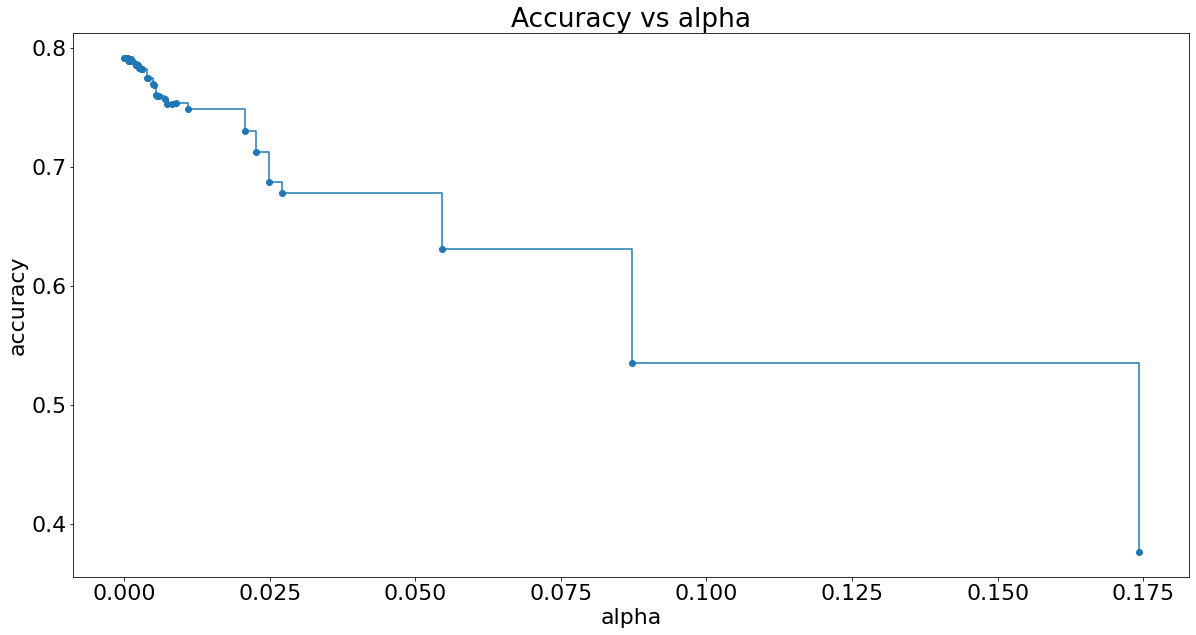

In [35]:
plt.figure(figsize=(20,10))
plt.plot(ccp_alphas_r, scores_r, marker='o', drawstyle="steps-post")
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.title("Accuracy vs alpha")
plt.show()

In [36]:
best_alpha_r = ccp_alphas_r[np.where(scores_r == np.max(scores_r))[0][0]]
len(ccp_alphas_r), np.where(scores_r == np.max(scores_r))[0][0], best_alpha_r

(47, 7, 0.00047560809892648455)

In [37]:
knowledger = DecisionTreeClassifier(max_depth=n_bins, ccp_alpha=best_alpha_r, random_state=seed_value)
knowledger.fit(X_r, dTarget_r)

DecisionTreeClassifier(ccp_alpha=0.00047560809892648455, max_depth=6,
                       random_state=30)

In [38]:
knowledger.score(X_r, dTarget_r)

0.8240657698056801

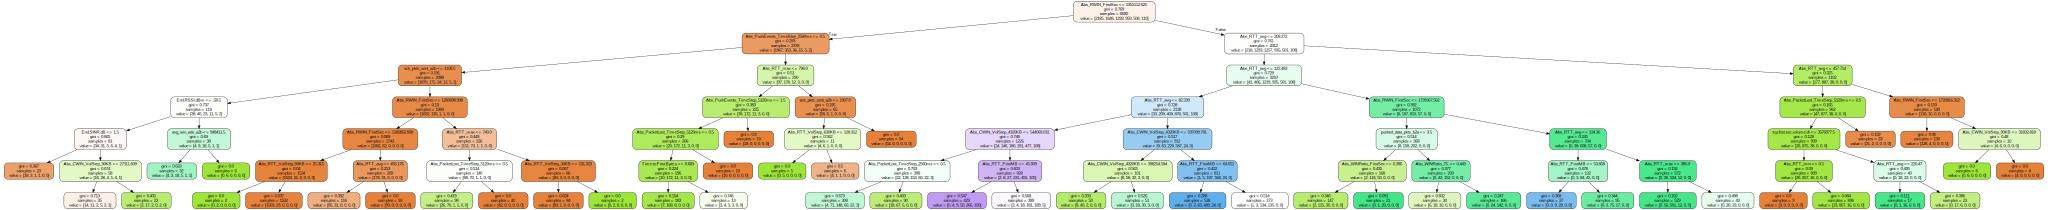

In [39]:
dot_data = tree.export_graphviz(knowledger, feature_names = np.array(X_r.columns), filled=True, rounded=True, out_file=None)
graph = graphviz.Source(dot_data)
graph

In [40]:
import pydotplus
graph_plus = pydotplus.graph_from_dot_data(dot_data)  
graph_plus.write_pdf("results/file_dl_82%.pdf")

True

In [41]:
y_pred_r = knowledger.predict(X_r)

In [157]:
val, count = np.unique(y_pred_r-dTarget_r, return_counts=True)

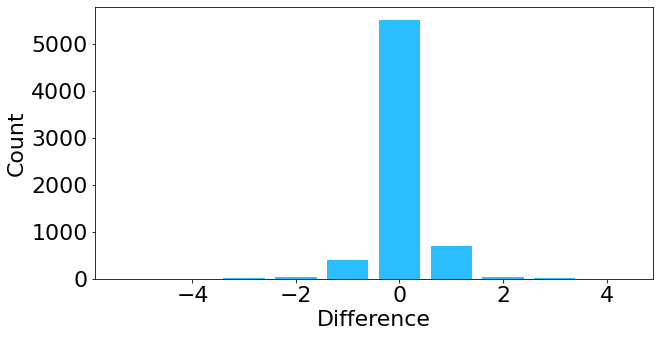

In [158]:
plt.figure(figsize=(10,5))
# matplotlib.rcParams.update({'font.size': 22})
plt.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.bar(x=val, height=count, color = "#2CBDFE")
plt.ylabel("Count")
plt.xlabel("Difference")
# plt.title("Diff between Predicted and Real")
plt.savefig("predi_real.pdf", bbox_inches='tight')
plt.show()

We are interested in values that performed worse than predicted

In [45]:
# Actual Throughput bad When it should be normal
X_r["Bad"] = (dTarget_r < y_pred_r)

In [46]:
np.sum(X_r["Bad"])

740

# Feature Selection

In [51]:
import JMI
from sklearn.feature_selection import mutual_info_regression

In [52]:
X_Badr = X_r[X_r["Bad"] == True]
y_Badr = y_r[X_r["Bad"] == True]

The (maximum) number of clusters is given by the size of the "bad" dataset

In [53]:
n_f = X_r.columns

In [54]:
n_clusters  = int(np.log2(len(y_Badr))/2)
n_clusters

4

In [55]:
# types = np.ones(1152)

In [56]:
n_features = n_clusters * n_clusters
n_features

16

In [57]:
miscodingr = Miscoding()

In [58]:
miscodingr.fit(X_Badr, y_Badr)
jmi = JMI.jmi(X_Badr.values, y_Badr, n_selected_features=n_features)
mir = mutual_info_regression(X_Badr, y_Badr)
best_mir = np.argsort(-mir)[0:n_features]

In [59]:
mscdr = miscodingr.miscoding_features(mode='adjusted')

In [60]:
column_names = np.array(X_Badr.columns)
best_jmi = jmi[0]
res = jmi[2]
jmi = jmi[1]
normalized_jmi = jmi / np.sqrt(np.sum(jmi**2))

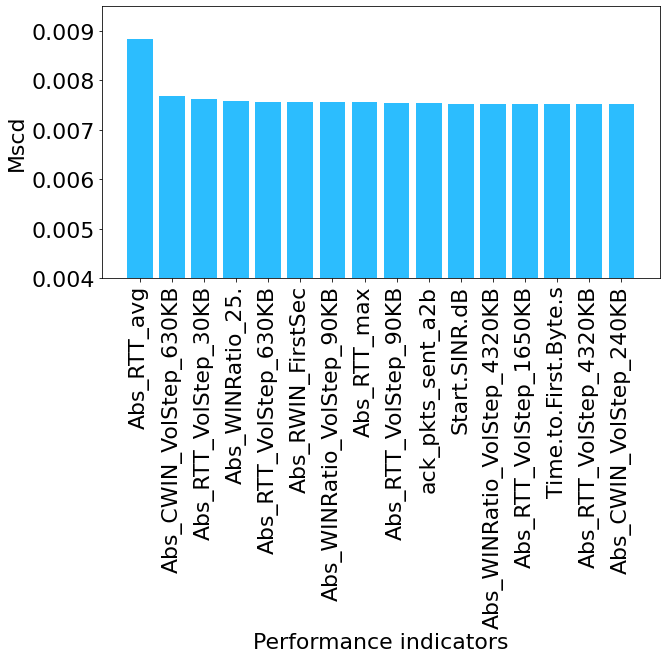

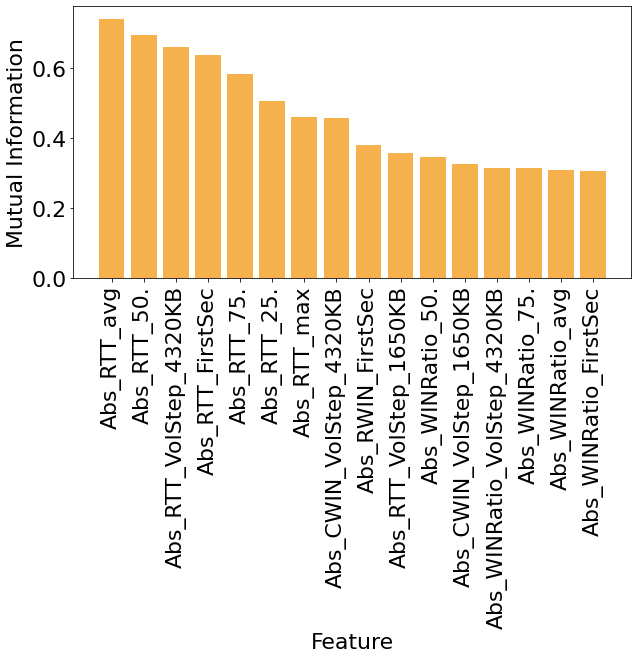

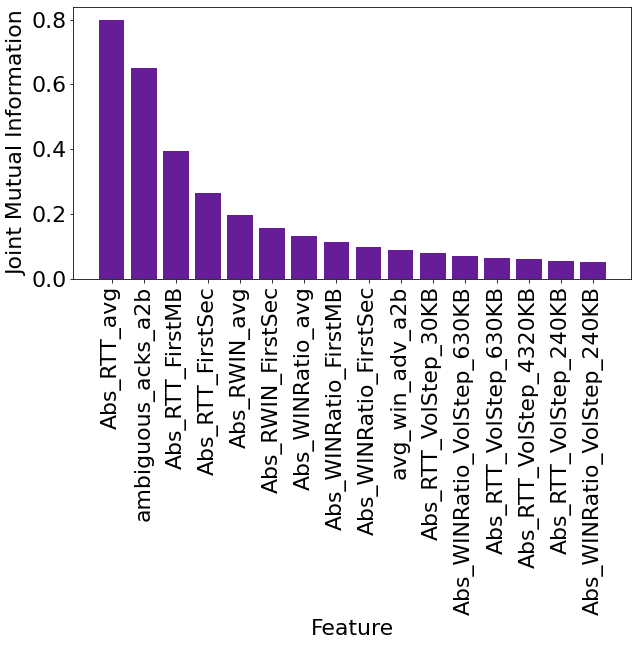

In [92]:
plt.figure(figsize=(10,5))
# matplotlib.rcParams.update({'font.size': 22})
plt.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


plt.bar(x=np.arange(0, len(np.argsort(-mscdr)[0:n_features])), color = "#2CBDFE", height=mscdr[np.argsort(-mscdr)[0:n_features]])
plt.xticks(np.arange(0, len(np.argsort(-mscdr)[0:n_features])), column_names[np.argsort(-mscdr)[0:n_features]], rotation=90)
plt.xlabel("Performance indicators")
plt.ylabel("Mscd")
plt.ylim([0.004, 0.0095])
# plt.title("Relevant Features")
plt.savefig("mscd_v1.pdf", bbox_inches='tight')

plt.show()
plt.figure(figsize=(10,5))
plt.bar(x=np.arange(0, len(best_mir)), height=mir[best_mir], color = "#F5B14C")
plt.xticks(np.arange(0, len(best_mir)), column_names[best_mir], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Mutual Information")
# plt.title("Ten Most Relevant Features")
plt.savefig("robust/mi.pdf", bbox_inches='tight')
plt.show()
plt.figure(figsize=(10,5))
plt.bar(x=np.arange(0, len(best_jmi)), height=normalized_jmi, color = "#661D98")
plt.xticks(np.arange(0, len(best_jmi)), column_names[best_jmi], rotation='vertical')
plt.xlabel("Feature")
plt.ylabel("Joint Mutual Information")
# plt.title("Most Relevant Features")
plt.savefig("robust/jmi.pdf", bbox_inches='tight')
plt.show()

In [62]:
best_mscd_vol = X_Badr.columns[np.argsort(-mir)[0:n_features]]
print(best_mscd_vol)
jmi_feat = column_names[best_jmi]
KPI_jmscd = [best_mscd_vol, jmi_feat]
values = mir[np.argsort(-mir)[0:n_features]]

Index(['Abs_RTT_avg', 'Abs_RTT_50.', 'Abs_RTT_VolStep_4320KB',
       'Abs_RTT_FirstSec', 'Abs_RTT_75.', 'Abs_RTT_25.', 'Abs_RTT_max',
       'Abs_CWIN_VolStep_4320KB', 'Abs_RWIN_FirstSec',
       'Abs_RTT_VolStep_1650KB', 'Abs_WINRatio_50.', 'Abs_CWIN_VolStep_1650KB',
       'Abs_WINRatio_VolStep_4320KB', 'Abs_WINRatio_75.', 'Abs_WINRatio_avg',
       'Abs_WINRatio_FirstSec'],
      dtype='object')


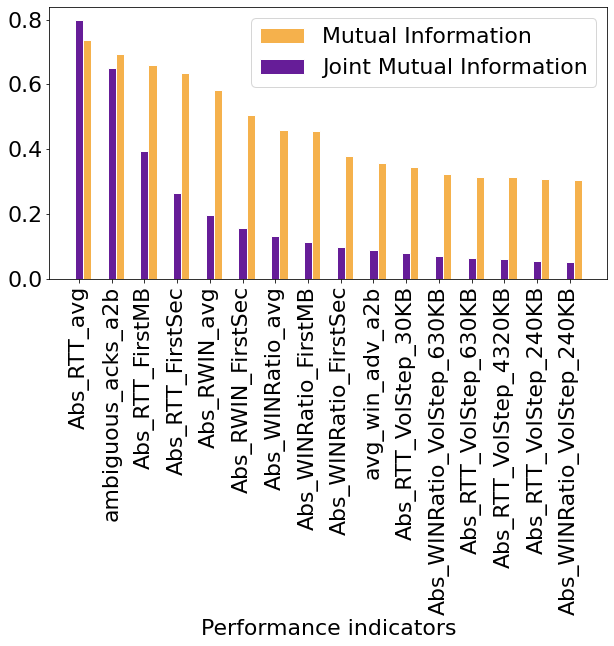

In [93]:
barWidth = 0.25
plt.figure(figsize=(10,5))
plt.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


# matplotlib.rcParams.update({'font.size': 22})

r1 = np.arange(0, len(best_jmi))
r2 = [x + barWidth for x in r1]
plt.bar(r2, mir[np.argsort(-mir)[0:n_features]], color= "#F5B14C", width=barWidth, edgecolor='white', label='Mutual Information')
plt.bar(r1, normalized_jmi, color="#661D98", width=barWidth, edgecolor='white', label='Joint Mutual Information')
 
# Add xticks on the middle of the group bars
plt.xlabel('Performance indicators')
plt.xticks(np.arange(0, len(best_jmi)), column_names[best_jmi], rotation=90)
# plt.xticks(np.arange(0, len(np.argsort(-mscd)[0:len(KPI_win)])), Xs_win.columns[np.argsort(-mscd)[0:len(KPI_win)]], rotation='vertical')

# Create legend & Show graphic
plt.legend()
plt.savefig("all.pdf", bbox_inches='tight')
plt.show()

In [184]:
km_modelr = KMeans(n_clusters=2)
# scalerr   = MinMaxScaler()
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
# scaler = PowerTransformer()
scalerr =  RobustScaler()

In [95]:
n_features 

16

In [196]:
best_mscdr = np.argsort(-mscdr)[0:n_features]
# attributesr = column_names[best_mscdr]
# attributesr = column_names[best_jmi]
attributesr = column_names[best_mir]


In [197]:
df = pd.DataFrame(columns = ["Attribute 1", "Attribute 2", "Inertia", "N Class 0", "N Class 1"])

for i in np.arange(len(attributesr)-1):
    
    for j in np.arange(i+1, len(attributesr)):
        
        new_Xr = X_Badr[[attributesr[i], attributesr[j]]]
#         print(new_X)
        new_Xr = scalerr.fit_transform(new_Xr)
    
        
        km_modelr.fit(new_Xr)
        
        y_predr = km_modelr.predict(new_Xr)

        tmp_df = pd.DataFrame([{"Attribute 1": attributesr[i], "Attribute 2": attributesr[j], "Inertia": km_modelr.inertia_,
                                "N Class 0":np.sum(y_predr==0), "N Class 1":np.sum(y_predr==1)}])

#         print(tmp_df)
        df = pd.concat([df, tmp_df], ignore_index=True)
df = df.astype({'N Class 0': 'int32', 'N Class 1': 'int32'})
df["Ratio"] = df["N Class 0"] / (df["N Class 0"] + df["N Class 1"])

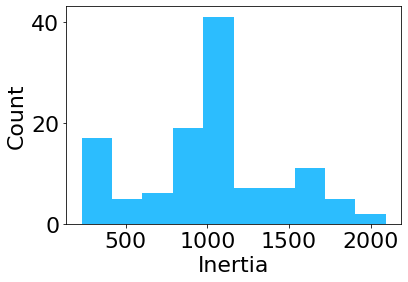

In [198]:
plt.hist(df["Inertia"], color = "#2CBDFE")
plt.ylabel("Count")
plt.xlabel("Inertia")
plt.savefig("NID/iner_filedl.pdf", bbox_inches='tight')
plt.show()

In [188]:
df.describe()

,Inertia,N Class 0,N Class 1,Ratio
count,120.000000,120.000000,120.000000,120.000000
mean,1655.884533,545.591667,194.408333,0.737286
std,975.801463,236.125643,236.125643,0.319089
min,142.376332,37.000000,2.000000,0.050000
25%,959.800030,571.000000,38.750000,0.771622
50%,1417.020699,670.000000,70.000000,0.905405
75%,2291.227915,701.250000,169.000000,0.947635
max,5902.412467,738.000000,703.000000,0.997297


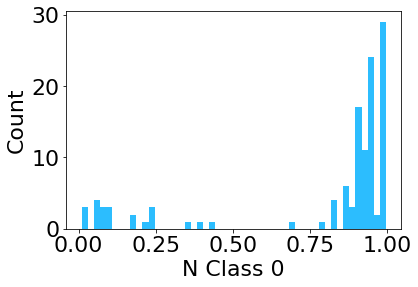

In [74]:
plt.hist(df["Ratio"], bins=50, color = "#2CBDFE")
plt.ylabel("Count")
plt.xlabel("N Class 0")
plt.savefig("NID/count_file.pdf", bbox_inches='tight')
plt.show()

In [75]:
np.sum(df['Ratio'] < 0.2)

15

In [76]:
np.sum(df['Ratio'] > 0.8)

96

In [199]:
red_matrix = np.zeros([df.shape[0], df.shape[0]])

for i in np.arange(df.shape[0]-1):
    
    for j in np.arange(i+1, df.shape[0]):
        new_Xr = X_Badr[[df["Attribute 1"][i], df["Attribute 2"][i]]]
#         new_X = scaler.fit_transform(new_X)

        km_modelr.fit(new_Xr)
        X1 = km_modelr.predict(new_Xr)
        
        new_Xr = X_Badr[[df["Attribute 1"][j], df["Attribute 2"][j]]]
#         new_X = scaler.fit_transform(new_X)

        km_modelr.fit(new_Xr)
        X2 = km_modelr.predict(new_Xr)
                
        unique, count = np.unique(X1, return_counts=True, axis=0)
        ldm_X1 = np.sum(count * ( - np.log2(count / len(X1))))

        unique, count = np.unique(X2, return_counts=True, axis=0)
        ldm_X2 = np.sum(count * ( - np.log2(count / len(X2))))
                
        Joint =  list(zip(X1, X2))
        unique, count = np.unique(Joint, return_counts=True, axis=0)
        ldm_X1X2 = np.sum(count * ( - np.log2(count / len(Joint))))
                                       
        tmp = (ldm_X1X2 - min(ldm_X1, ldm_X2) ) / max(ldm_X1, ldm_X2)
                                
        red_matrix[i, j] = tmp
        red_matrix[j, i] = tmp


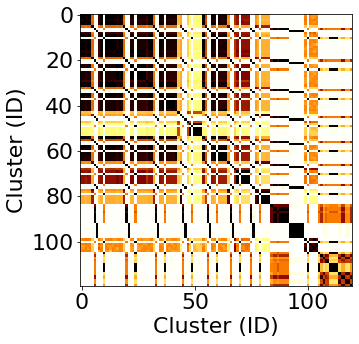

In [200]:
plt.figure(figsize=(10,5))
plt.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.imshow(red_matrix, cmap='afmhot', interpolation='nearest')
plt.xlabel("Cluster (ID)")
plt.ylabel("Cluster (ID)")
plt.savefig("NID_file_MI.pdf", bbox_inches='tight')
plt.show()

In [79]:
red_matrix[30,30]

0.0

In [80]:
m =red_matrix.diagonal()                          
print("diagonal elements \n:", m)

diagonal elements 
: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Identify the threshold for the miscoding

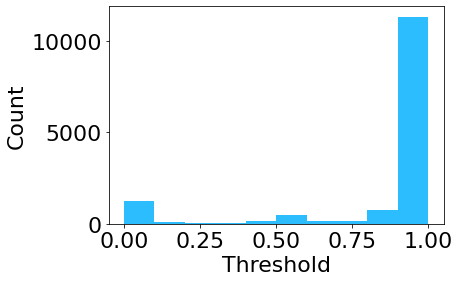

In [81]:
plt.hist(red_matrix.reshape(-1, 1), color = "#2CBDFE")
plt.ylabel("Count")
plt.xlabel("Threshold")
plt.savefig("NID/thres_filedl.pdf", bbox_inches='tight')
plt.show()

In [90]:
final_df    = pd.DataFrame(columns = ["Attribute 1", "Attribute 2", "Inertia", "N Class 0", "N Class 1", "Ratio"])
attr_in_use = list()
redundant   = list()

att_not_use_redundant = list()
threshold   = 0.8
filter_ratio_low   = 0.2
filter_ration_high = 0.8

nc = n_clusters

for index, row in df.sort_values(by=['Inertia'], ascending=True).iterrows():
    
    index = int(index)
  
    # Avoid redundant clusters
    
    if index in redundant:
        continue

    # Avoid unbalanced clusters
    
    if row['Ratio'] < filter_ratio_low:
        continue
        
    if row['Ratio'] > filter_ration_high:
        continue
                
    attr_in_use.append(row["Attribute 1"])
    attr_in_use.append(row["Attribute 2"])
    
    new_red   = list(np.where(red_matrix[index] < threshold)[0])    
    redundant = list(set(redundant) | set(new_red))

    tmp_df = pd.DataFrame([{"Attribute 1": row["Attribute 1"], "Attribute 2": row["Attribute 2"], "Inertia": row["Inertia"],
                                "N Class 0":row["N Class 0"], "N Class 1":row["N Class 1"], "Ratio":row["Ratio"]}])
   

    final_df = pd.concat([final_df, tmp_df], ignore_index=True)
  
    nc = nc - 1
        
    if nc == 0:
        break

In [91]:
final_df

,Attribute 1,Attribute 2,Inertia,N Class 0,N Class 1,Ratio
0,Abs_WINRatio_25.,Abs_WINRatio_VolStep_4320KB,310.426132,176,564,0.237838
1,Abs_WINRatio_25.,Start.SINR.dB,466.348575,507,233,0.685135
2,Abs_WINRatio_25.,ack_pkts_sent_a2b,493.034851,291,449,0.393243
3,Abs_RTT_VolStep_630KB,Start.SINR.dB,657.722640,158,582,0.213514


In [84]:
red_a = df.iloc[redundant]

In [85]:
unbalanced_1 = df[df['Ratio'] < 0.2] 
unbalanced_2 = df[df['Ratio'] > 0.8] 
unbalan = pd.concat([unbalanced_1, unbalanced_2])

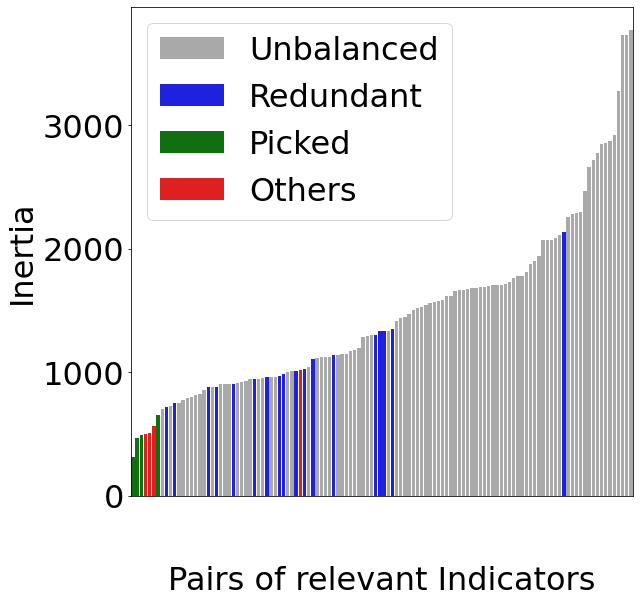

In [203]:
from matplotlib import pyplot as plt
import seaborn as sns
matplotlib.rcParams.update({'font.size': 32})

plt.figure(figsize=(9,9))
plt.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.barplot(x='ID', y='Inertia', hue='Tag', data=alll, dodge=False, order=alll.sort_values('Inertia').ID, palette=["darkgrey", "blue","green", "red"])
# plt.xticks(rotation=90)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.gca().legend().set_title('')

# def change_width(ax, new_value) :
#     for patch in ax.patches :
#         current_width = patch.get_width()
#         diff = current_width - new_value

#         # we change the bar width
#         patch.set_width(new_value)

#         # we recenter the bar
#         patch.set_x(patch.get_x() + diff * .5)


plt.xlabel("Pairs of relevant Indicators",labelpad=70)
plt.savefig("iD.pdf",bbox_inches='tight')

plt.show()



In [ ]:
plt.bar(X_pos, CTE, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10, color= "red")
plt.bar(X_pos, CTE, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10, color = "blue")
plt.bar(X_pos, CTE, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10, color = "green")
plt.bar(X_pos, CTE, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10, color = "yellow")


In [ ]:
import matplotlib.lines as mlines
km_modelr = KMeans(n_clusters=2)

type = 1

for index, row in final_df.iterrows():
    
    new_Xr = X_r[X_r["Bad"]][[row["Attribute 1"], row["Attribute 2"]]]
    new_X_s = scalerr.fit_transform(new_Xr)
    km_modelr.fit(new_X_s)

    y_predr = km_modelr.predict(new_X_s)
#     print(y_pred)
    A = plt.scatter(new_Xr[y_predr == 0][row["Attribute 1"]], new_Xr[y_predr == 0][row["Attribute 2"]], c="salmon", label = "A")
    B = plt.scatter(new_Xr[y_predr == 1][row["Attribute 1"]], new_Xr[y_predr == 1][row["Attribute 2"]], c="turquoise", label = "B")
    C = plt.plot(row["Inertia"], c="red", label = "$" + str(row["Inertia"]) + "$")
    plt.autoscale(enable = True, axis = "both")

    plt.xlabel(row["Attribute 1"])
    plt.ylabel(row["Attribute 2"])
    plt.title("Type " + str(type))
    C = row["Inertia"]
    D = row["Ratio"]
 
#     plt.ylim([-120, -50])

    plt.legend(handles = [A, B])
    plt.savefig("type" + str(index) + ".pdf", bbox_inches='tight')
    print("Inertia:", C)
    print("Label 0:", len(new_Xr[y_predr == 0]))
    print("Label 1:", len(new_Xr[y_predr == 1]))
    print("Ratio:", D)

    plt.show()
    type = type + 1

/home/marine/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support <AxesSubplot:title={'center':'Type 1'}, xlabel='Abs_WINRatio_25.', ylabel='Abs_WINRatio_VolStep_4320KB'> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


Inertia: 310.4261323750532
Label 0: 176
Label 1: 564
Ratio: 0.23783783783783785


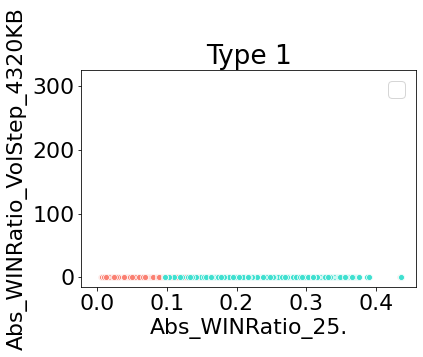

/home/marine/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support <AxesSubplot:title={'center':'Type 2'}, xlabel='Abs_WINRatio_25.', ylabel='Start.SINR.dB'> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


Inertia: 466.34857473374626
Label 0: 507
Label 1: 233
Ratio: 0.6851351351351351


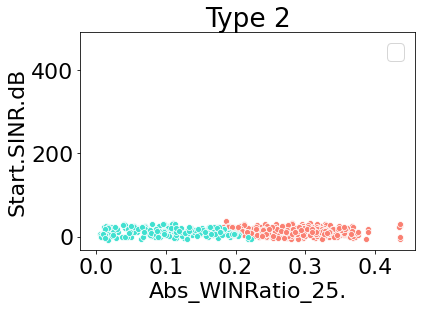

/home/marine/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support <AxesSubplot:title={'center':'Type 3'}, xlabel='Abs_WINRatio_25.', ylabel='ack_pkts_sent_a2b'> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


Inertia: 493.03485099750765
Label 0: 444
Label 1: 296
Ratio: 0.3932432432432432


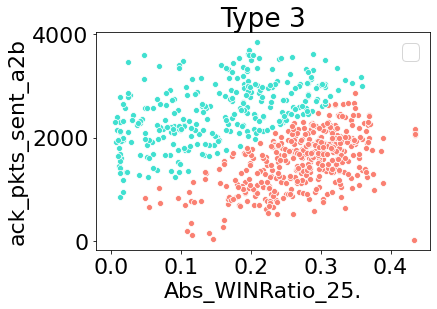

/home/marine/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Legend does not support <AxesSubplot:title={'center':'Type 4'}, xlabel='Abs_RTT_VolStep_630KB', ylabel='Start.SINR.dB'> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


Inertia: 657.7226396442369
Label 0: 158
Label 1: 582
Ratio: 0.21351351351351353


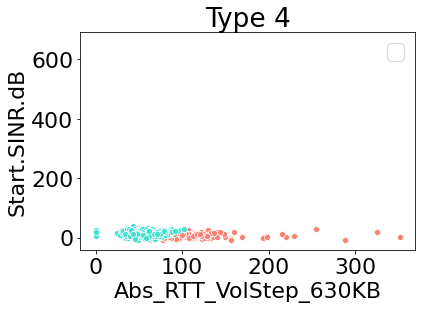

In [136]:
import matplotlib.lines as mlines
km_modelr = KMeans(n_clusters=2)

type = 1

for index, row in final_df.iterrows():
    
    new_Xr = X_r[X_r["Bad"]][[row["Attribute 1"], row["Attribute 2"]]]
    new_X_s = scalerr.fit_transform(new_Xr)
    km_modelr.fit(new_X_s)

    y_predr = km_modelr.predict(new_X_s)
#      sns.scatterplot(x="total_bill", y="tip", data=tips)
#     print(y_pred)
    A = sns.scatterplot(new_Xr[y_predr == 0][row["Attribute 1"]], new_Xr[y_predr == 0][row["Attribute 2"]], color="salmon")
    B = sns.scatterplot(new_Xr[y_predr == 1][row["Attribute 1"]], new_Xr[y_predr == 1][row["Attribute 2"]], color="turquoise")
    C = plt.plot(row["Inertia"], c="red", label = "$" + str(row["Inertia"]) + "$")
    plt.autoscale(enable = True, axis = "both")

    plt.xlabel(row["Attribute 1"])
    plt.ylabel(row["Attribute 2"])
    plt.title("Type " + str(type))
    C = row["Inertia"]
    D = row["Ratio"]
 
#     plt.ylim([-120, -50])

    plt.legend(handles = [A, B])
    plt.savefig("type" + str(index) + ".pdf", bbox_inches='tight')
    print("Inertia:", C)
    print("Label 0:", len(new_Xr[y_predr == 0]))
    print("Label 1:", len(new_Xr[y_predr == 1]))
    print("Ratio:", D)

    plt.show()
#     sns.jointplot(A, B, kind="kde")

    type = type + 1

In [137]:
attributes = np.concatenate((final_df["Attribute 1"].values, final_df["Attribute 2"].values))
attributes

array(['Abs_WINRatio_25.', 'Abs_WINRatio_25.', 'Abs_WINRatio_25.',
       'Abs_RTT_VolStep_630KB', 'Abs_WINRatio_VolStep_4320KB',
       'Start.SINR.dB', 'ack_pkts_sent_a2b', 'Start.SINR.dB'],
      dtype=object)

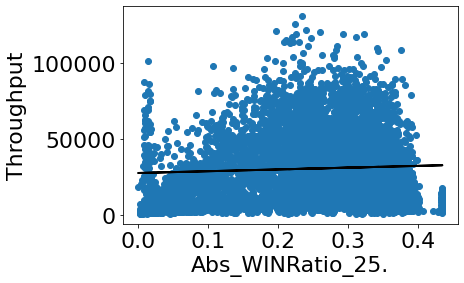

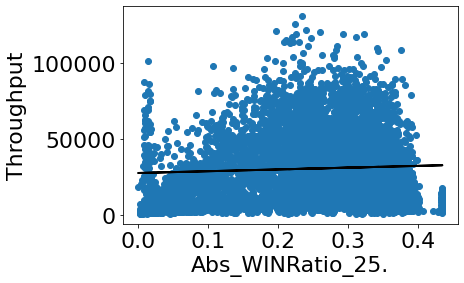

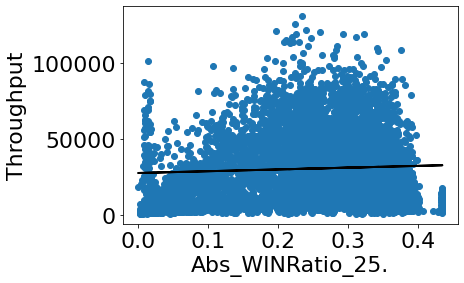

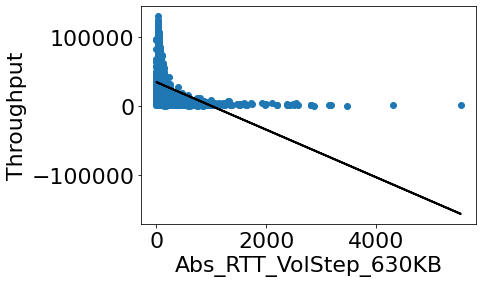

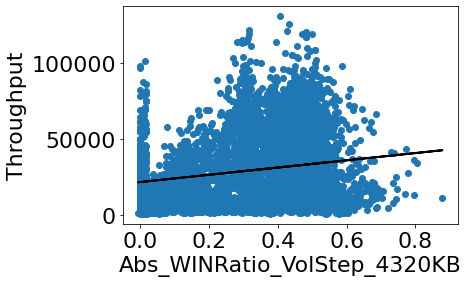

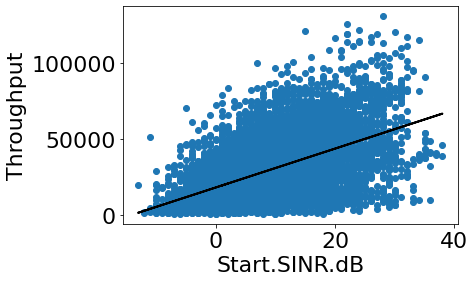

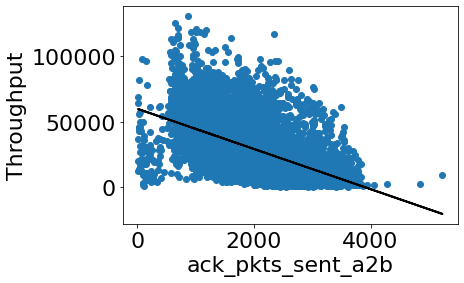

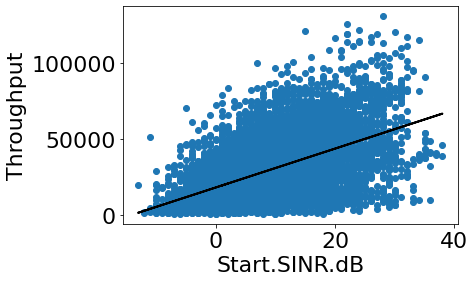

In [148]:
regr = LinearRegression(fit_intercept=True, )

coefs = []

# for attr in attributes:
        
#     plt.scatter(X_Badr[attr], y_Badr)
#     plt.xlabel(attr)
#     plt.ylabel("Throughput (kbit/s)")
    
#     regr.fit(np.array(X_Badr[attr]).reshape(-1, 1), y_Badr)

#     coefs.append(regr.coef_[0])
    
#     y_pred = regr.predict(np.array(X_Badr[attr]).reshape(-1, 1))
#     plt.plot(X_Badr[attr], y_pred, color='black', linewidth=2)

#     plt.show()
    
# attributes_df = pd.DataFrame({"Attribute": attributes, "Coefficients": coefs})
# regr = LinearRegression(fit_intercept=True)

coefs = []

for attr in attributes:
        
    plt.scatter(data[attr], data["Test.Throughput.kbit.s"])
    plt.xlabel(attr)
    plt.ylabel("Throughput")
    
    regr.fit(np.array(data[attr]).reshape(-1, 1), data["Test.Throughput.kbit.s"])

    coefs.append(regr.coef_[0])
    
    y_pred = regr.predict(np.array(data[attr]).reshape(-1, 1))
    plt.plot(data[attr], y_pred, color='black', linewidth=2)

    plt.show()
    
attributes_df = pd.DataFrame({"Attribute": attributes, "Coefficients": coefs})

Remove duplicates

In [149]:
attributes_df = attributes_df[attributes_df.duplicated() == False]

In [ ]:
final_df.iloc[[3]]

Draw the final clusters

/home/marine/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


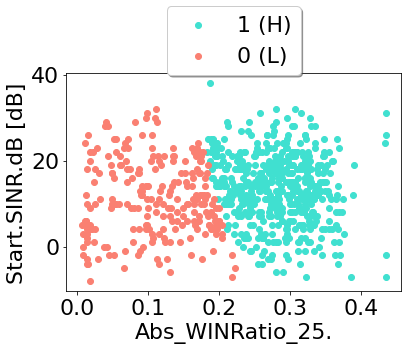

In [155]:
km_modelr = KMeans(n_clusters=2)

type = 1
plt.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# final_df_s = final_df.iloc[[1]]
for index, row in final_df_s.iterrows():
        
    new_Xr = X_r[X_r["Bad"]][[row["Attribute 1"], row["Attribute 2"]]]
#     km_model.fit(new_X)
    new_X_s = scalerr.fit_transform(new_Xr)
    km_modelr.fit(new_X_s)

    y_predr = km_modelr.predict(new_X_s)
#     y_pred = km_model.predict(new_X)
    
    if min(new_Xr[y_predr == 0][row["Attribute 1"]]) < min(new_Xr[y_predr == 0][row["Attribute 1"]]):
    
        A = plt.scatter(new_Xr[y_predr == 0][row["Attribute 1"]], new_Xr[y_predr == 0][row["Attribute 2"]], c="turquoise")
        B = plt.scatter(new_Xr[y_predr == 1][row["Attribute 1"]], new_Xr[y_predr == 1][row["Attribute 2"]], c="salmon")
        
    else:
        
        A = plt.scatter(new_Xr[y_predr == 1][row["Attribute 1"]], new_Xr[y_predr == 1][row["Attribute 2"]], c="turquoise")
        B = plt.scatter(new_Xr[y_predr == 0][row["Attribute 1"]], new_Xr[y_predr == 0][row["Attribute 2"]], c="salmon")
        
    
    if float(attributes_df[attributes_df["Attribute"] == row["Attribute 1"]]["Coefficients"]) < 0:
        print("reverse", row["Attribute 1"])
        plt.gca().invert_xaxis()

    if float(attributes_df[attributes_df["Attribute"] == row["Attribute 2"]]["Coefficients"]) < 0:
        print("reverse", row["Attribute 2"])
        plt.gca().invert_yaxis()
    ax = plt.subplot(111)
    plt.xlabel(row["Attribute 1"])
    plt.ylabel("Start.SINR.dB [dB]")
#     plt.title("Dependency " + str(type))
#     plt.legend((A, B), ("No Problem", "Problem"))
#     plt.legend((A, B), ("Positively Correlated", "Negatively Correlated"))
#     box = ax.get_position()
#     ax.set_position([box.x0, box.y0, box.width * 1, box.height])

# Put a legend below current axis
    ax.legend((A, B), ("1 (H)", "0 (L)"),loc='center', bbox_to_anchor=(0.5, 1.15),
          ncol=1, fancybox=True, shadow=True)
#     plt.legend((A, B), ("Positive Dependency", "Negative Dependency"))
#     bbox = fig.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#     width, height = bbox.width*fig.dpi, bbox.height*fig.dpi
#     print(width, height)

    plt.savefig("me" + str(index) + ".pdf", bbox_inches='tight')

    plt.show()
#     print(type)
    type = type + 1

Build final Dataset

In [ ]:
final_df.to_csv("final.csv")

In [ ]:
km_modelr = KMeans(n_clusters=2)

type = 1
problem = [""] * len(y_predr)

for index, row in final_df.iterrows():

    new_Xr = X_r[X_r["Bad"]][[row["Attribute 1"], row["Attribute 2"]]]

    new_X_s = scalerr.fit_transform(new_Xr)
    km_modelr.fit(new_X_s)
    y_predr = km_modelr.predict(new_X_s)
    
#Rafa no Normalization    
#     km_model.fit(new_X)
    
#     y_pred = km_model.predict(new_X)
    print("#-------------------------- Class 0 --------------------------#")
    print("Df:", new_Xr[y_predr == 0])
    print("Shape:", new_Xr[y_predr == 0].shape)
    print("#-------------------------- Class 1 --------------------------#")
    print("Df:", new_Xr[y_predr == 1])
    print("Shape:", new_Xr[y_predr == 1].shape)


#     print("y_pred = ", y_pred)
    
    # Reverse the order of predicted classes, so 0 is the class closer to origin
    
    if min(new_Xr[y_predr == 0][row["Attribute 1"]]) > min(new_Xr[y_predr == 1][row["Attribute 1"]]):    
        y_predr = 1 - y_predr

    # Reverse again if the attributes are negative correlated with throughtput    
        
    if float(attributes_df[attributes_df["Attribute"] == row["Attribute 1"]]["Coefficients"]) < 0 and float(attributes_df[attributes_df["Attribute"] == row["Attribute 2"]]["Coefficients"]) < 0:
        y_predr = 1 - y_predr

    for i in np.arange(len(y_predr)):
        
        if y_predr[i] == 0:
            problem[i] = problem[i] + "D" + str(type) + "NC;"
        else:
            problem[i] = problem[i] + "D" + str(type) + "PC;"
            
    type = type + 1

In [ ]:
X_r["Problem"] = ["No Problem"] * X_r.shape[0]
X_r.loc[X_r["Bad"], "Problem"] = problem

Unknown problem

In [ ]:
X_r.loc[X_r["Problem"] == "D1NC;D2NC;D3NC;D4NC;", "Problem"] = "Unknown"
# X.loc[X["Problem"] == "T1N;T2N;T3N;", "Problem"] = "Uknown"

In [ ]:
np.unique(X_r["Problem"], return_counts=True)

## Final Tree On Bad_samples

In [ ]:
from sklearn.utils import resample


In [ ]:
Xs_modelr = X_r[X_r["Bad"] == True]


In [ ]:
# Xs_modelr= resample(Xs_modelr,
#                           replace=True, # sample with replacement
#                           n_samples=len(X_r["Bad"] == False), # match number in majority class
#                           random_state=27) # reproducible results

In [ ]:
Y_labeledr = Xs_modelr["Problem"]
Xs_modelr = Xs_modelr.drop(columns = ["Problem"])

In [ ]:
len(Y_labeledr)

In [ ]:
dp = int(np.log2(len(Y_labeledr))/2)
dp

In [ ]:
clfr = DecisionTreeClassifier(min_samples_leaf=5, max_depth=dp, random_state=seed_value)
pathr = clfr.cost_complexity_pruning_path(Xs_modelr, Y_labeledr)
ccp_alphasr, impuritiesr = pathr.ccp_alphas, pathr.impurities

In [ ]:
clfsr = []
for ccp_alpha in ccp_alphasr:
    clfr = DecisionTreeClassifier(min_samples_leaf=5, max_depth=dp, ccp_alpha=ccp_alpha, random_state=seed_value)
    clfr.fit(Xs_modelr, Y_labeledr)
    clfsr.append(clfr)

In [ ]:
scores = [cross_val_score(clfr, Xs_modelr, Y_labeledr, cv=30, n_jobs=-1).mean() for clfr in clfsr]

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(ccp_alphasr, scores, marker='o', drawstyle="steps-post")
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.title("Accuracy vs alpha")
plt.show()

In [ ]:
best_alphar = ccp_alphasr[np.where(scores == np.max(scores))[0][0]]
len(ccp_alphasr), np.where(scores == np.max(scores))[0][0], best_alphar

In [ ]:
# finalr = DecisionTreeClassifier(max_depth=dp, min_samples_leaf=5, ccp_alpha=best_alphar)
finalr = DecisionTreeClassifier(max_depth=3)

finalr.fit(Xs_modelr, Y_labeledr)

In [ ]:
finalr.score(Xs_modelr, Y_labeledr)

In [ ]:
finalr.classes_

In [ ]:
dot_data = tree.export_graphviz(finalr, feature_names = np.array(Xs_modelr.columns), class_names=finalr.classes_, filled=True, rounded=True, out_file=None)
graph = graphviz.Source(dot_data)
graph

In [ ]:
import pydotplus
graph_plus = pydotplus.graph_from_dot_data(dot_data)  
graph_plus.write_png("NID/badsample100%.png")

In [ ]:
# tree_data = Xs_model
# tree_data = tree_data[tree_data["Abs_WINRatio_25."] <= 0.198]
# print("First Lvl", tree_data.shape)
# tree_data = tree_data[tree_data["Abs_CWIN_VolStep_4320KB"] <= 596588.938]
# print("Second Lvl", tree_data.shape)
# tree_data = tree_data[tree_data["Abs_WINRatio_25."] > 0.174]
# print("Third Lvl", tree_data.shape)
# t3_t4 = tree_data
# # f = plt.figure()
# plt.figure(figsize=(15,10))

# plt.rc('text', usetex=False)

# plt.rcParams.update({'font.size': 20})
# plt.subplot(2, 2, 1)

# plt.scatter(t3_t4["Time.to.First.Byte.s"], t3_t4["End.RSRP.dBm"], c = "red")
# plt.xlabel("Time.to.First.Byte.s [s]")
# plt.ylabel("End.RSRP.dBm [dBm]")
# plt.title("Type 3")
# plt.subplot(2, 2, 2)
# plt.scatter(t3_t4["Abs_RTT_max"], t3_t4["End.RSRP.dBm"], cmap = "coolwarm")
# plt.xlabel("Abs_RTT_TimeStep_40ms [ms]")
# plt.title("Type 4")
# plt.ylabel("End.RSRP.dBm [dBm]")
# plt.subplot(2, 2, 3)
# plt.scatter(t3_t4["Abs_RWIN_avg"], t3_t4["Abs_RWIN_max"], c = "green")
# plt.xlabel("Abs_RWIN_min")
# plt.ylabel("Abs_RWIN_max")
# # plt.savefig("type.pdf",  bbox_inches='tight')
# plt.show()




In [ ]:
# tree_data = Xs_model
# tree_data = tree_data[tree_data["End.RSRP.dBm"] > -87.5]
# print("First Lvl", tree_data.shape)
# tree_data = tree_data[tree_data["Abs_RTT_VolStep_90KB"] <= 71.066]
# print("Second Lvl", tree_data.shape)
# tree_data = tree_data[tree_data["Abs_RTT_max"] > 440.5]
# print("Third Lvl", tree_data.shape)
# t3_t4 = tree_data
# # f = plt.figure()
# plt.figure(figsize=(15,10))

# plt.rc('text', usetex=False)

# plt.rcParams.update({'font.size': 20})
# plt.subplot(2, 2, 1)

# plt.scatter(t3_t4["Time.to.First.Byte.s"], t3_t4["End.RSRP.dBm"], c = "red")
# plt.xlabel("Time.to.First.Byte.s [s]")
# plt.ylabel("End.RSRP.dBm [dBm]")
# plt.title("Type 3")
# plt.subplot(2, 2, 2)
# plt.scatter(t3_t4["Abs_RTT_max"], t3_t4["End.RSRP.dBm"], cmap = "coolwarm")
# plt.xlabel("Abs_RTT_max [ms]")
# plt.title("Type 4")
# plt.ylabel("End.RSRP.dBm [dBm]")
# plt.subplot(2, 2, 3)
# plt.scatter(t3_t4["Abs_RWIN_avg"], t3_t4["Abs_RWIN_max"], c = "green")
# plt.xlabel("Abs_RWIN_min")
# plt.ylabel("Abs_RWIN_max")
# # plt.savefig("type.pdf",  bbox_inches='tight')
# plt.show()




In [ ]:
import pydotplus
graph_plus = pydotplus.graph_from_dot_data(dot_data)  
graph_plus.write_pdf("robust/file_dl_94%.pdf")

# Train the final Tree

In [ ]:
Xs_modelr = X_r[X_r["Bad"] == True]


In [ ]:
Xs_modelr = resample(Xs_modelr,
                          replace=True, # sample with replacement
                          n_samples=len(X_r["Bad"] == False), # match number in majority class
                          random_state=56) # reproducible results

In [ ]:

fXr = X_r.copy()
fxr = fXr[fXr["Problem"] == "No Problem"] 
# fXr = pd.concat([Xs_modelr, fxr])
fXr.shape
fyr = fXr["Problem"]
fXr = fXr.drop(["Bad", "Problem"], axis=1)
f_column_names = np.array(fXr.columns)

In [ ]:
dp = int(np.log2(len(fyr))/2)
dp

In [ ]:
clf = DecisionTreeClassifier(min_samples_leaf=5, max_depth=dp, random_state=seed_value)
path = clf.cost_complexity_pruning_path(fXr, fyr)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(min_samples_leaf=5, max_depth=dp, ccp_alpha=ccp_alpha, random_state=seed_value, class_weight= "balanced")
    clf.fit(fXr, fyr)
    clfs.append(clf)

In [ ]:
scores = [cross_val_score(clf, fXr, fyr, cv=30, n_jobs=-1).mean() for clf in clfs]

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(ccp_alphas, scores, marker='o', drawstyle="steps-post")
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.title("Accuracy vs alpha")
plt.show()

In [ ]:
best_alpha = ccp_alphas[np.where(scores == np.max(scores))[0][0]]
len(ccp_alphas), np.where(scores == np.max(scores))[0][0], best_alpha

In [ ]:
final = DecisionTreeClassifier(max_depth=dp, min_samples_leaf=5, ccp_alpha=best_alpha, random_state=seed_value)
# final = DecisionTreeClassifier(max_depth=3)

final.fit(fXr, fyr)

In [ ]:
final.score(fXr, fyr)

In [ ]:
final.classes_

In [ ]:
dot_data = tree.export_graphviz(final, feature_names = np.array(fXr.columns), class_names=final.classes_, filled=True, rounded=True, out_file=None)
graph = graphviz.Source(dot_data)
graph

In [ ]:
import pydotplus
graph_plus = pydotplus.graph_from_dot_data(dot_data)  
graph_plus.write_png("NID/final_dl_90%.png")